# PLACEHOLDER FOR TITLE

## PLACEHOLDER FOR DESCRIPTION

### PACKAGES AND LIBRARIES

In [6]:
# Here is all the libs needed to do the analysis and plotting for "TITLE AND THONG"
# python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import xarray as xr

In [2]:
# R packages
import rpy2

%load_ext rpy2.ipython

In [3]:
%%R
library(tidyverse) 
library(zoo)
library(ggtree)
library(ape)
library(ggimage)
library(ggpubr)
library(ggridges)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


R[write to console]: 
Attaching package: ‘zoo’


R[write to console]: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


R[write to console]: ggtree v3.10.0 For help: https://yulab-smu.top/treedata-book/

If you use the ggtree package suite in published research, please cite
the appropriate paper(s):

Guangchuang Yu, David Smith, Huachen Zhu, Yi Guan, Tommy Tsan-Yuk Lam.
ggtree: an R package for visualization and annotation of phylogenetic
trees with their covariates and other associated data. Methods in
Ecology and Evolution. 2017, 8(1):28-36. doi:10.1111/2041-210X.12628

Shuangbin Xu, Lin Li, Xiao Luo, Meijun Chen, Wenli Tang, Li Zhan, Zehan
Dai, Tommy T. Lam, Yi Guan, Guangchuang Yu. Ggtree: A serialized data
object for visualization of a phylogenetic tree and annotation data.
iMeta 2022, 1(4):e56. doi:10.1002/imt2.56

Guangchuang Yu, Tommy Tsan-Yuk Lam, Huachen Zhu, Yi Guan. Two methods
for mapping and visualizing associated data on phylogeny usin

In [4]:
%%R

posterior_predictive <- function(x, slope_samples, intercept_samples) {
  slope_samples * x + intercept_samples
}

# Calculate the credibility interval
credibility_interval <- function(x, slope_samples, intercept_samples, prob = c(0.025, 0.975)) {
  quantile(posterior_predictive(x, slope_samples, intercept_samples), prob)
}

# Merging with phylogenetic grouping, removing chrX, Low callability regions and NaNs

In [6]:
# load raw dataframes (Only for the first time, downstream use the saved dataframes)
df = pd.read_csv('../data/stats/all_species.combined.stats.csv', sep = ',')
pg_names = pd.read_csv('../data/genus_phylogenetic_group_metadata.txt', sep = '\t')
# get phylogenetic group names
df['genus'] = df['species'].str.split('_').str[0]
df['phylogenetic_group'] = df['genus'].map(pg_names.set_index('genus')['pg_name'])
# Filter regions away that are freq_median < 0.5 or chrX and remove NANs
df = df[df['chrom'] != 'chrX']
df = df[df['freq_median'] > 0.5]
# Drop NaN values in recombination rate
df = df.dropna(subset=['cm_start', 'cm_end', 'cm_per_mb'])
# Save the filtered dataframe
df.to_csv('../results/stats/all_species.combined.stats.filtered.csv', index=False)


,chrom,start,end,n_variants,diversity,n_singletons,singleton_proportion,tajima_d,bases,cm_start,cm_end,cm_per_mb,freq_mean,freq_min,freq_max,freq_median,window_size_mean,sum_n_mean,species
0,chr1,1,100000,173,0.000090,1.0,0.005780,2.002212,100000,NaN,NaN,NaN,0.004338,0.003720,0.004730,0.004365,99999.0,433.750000,Cheracebus_lugens
1,chr1,100001,200000,835,0.000158,20.0,0.023952,-0.200994,100000,NaN,NaN,NaN,0.015111,0.012820,0.017430,0.015280,99999.0,1511.125000,Cheracebus_lugens
2,chr1,200001,300000,763,0.000379,8.0,0.010485,0.706893,100000,NaN,NaN,NaN,0.014405,0.010910,0.020690,0.014390,99999.0,1440.500000,Cheracebus_lugens
3,chr1,300001,400000,330,0.000024,3.0,0.009091,-0.776995,100000,NaN,NaN,NaN,0.012228,0.011950,0.012370,0.012235,99999.0,1222.750000,Cheracebus_lugens
4,chr1,400001,500000,121,0.000026,8.0,0.066116,-1.123225,100000,NaN,NaN,NaN,0.000925,0.000430,0.001460,0.000830,99999.0,92.500000,Cheracebus_lugens
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4972824,chrX,155600001,155700000,1393,0.001162,107.0,0.076813,0.095603,100000,NaN,NaN,NaN,0.836486,0.211532,0.915019,0.908759,99999.0,77839.153846,Pan_paniscus
4972825,chrX,155700001,155800000,1189,0.000626,135.0,0.113541,-1.022861,100000,NaN,NaN,NaN,0.848685,0.211012,0.934139,0.924919,99999.0,79377.538462,Pan_paniscus
4972826,chrX,155800001,155900000,1476,0.000747,112.0,0.075881,-0.340386,100000,NaN,NaN,NaN,0.850099,0.213392,0.929509,0.921809,99999.0,78971.692308,Pan_paniscus
4972827,chrX,155900001,156000000,1405,0.001113,105.0,0.074733,-0.072809,100000,NaN,NaN,NaN,0.805237,0.165102,0.900909,0.886019,99999.0,74607.307692,Pan_paniscus


# Tajimas D data

In [ ]:
# # Remove species with less than 5 valid samples
# tajimas_d = pd.read_csv('../results/stats/all_species.combined.stats.filtered.csv', sep = ',')
# valid_species_count = pd.read_csv('../data/valid_species_counts.csv', sep = ',')
# # Merge with valid_species_count and filter species with less than 5 valid samples
# tajimas_d = tajimas_d.merge(valid_species_count, on='species')
# tajimas_d = tajimas_d[tajimas_d['valid_samples'] >= 5]
# tajimas_d.to_csv('../results/stats/tajimas_d.filtered.csv', index=False)

In [5]:
%%R
df <- read_delim('../results/stats/tajimas_d.filtered.csv') %>% group_by(species) %>% mutate(rec_bin = ntile(cm_per_mb, 20))

Rows: 581912 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): chrom, species, genus, phylogenetic_group
dbl (18): start, end, n_variants, diversity, n_singletons, singleton_proport...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
%%R
# Calculate mean values per species and rec_bin for visualization
df_summary <- df %>% 
    group_by(species, phylogenetic_group, rec_bin) %>%
    summarise(
        median_tajimas_d = median(tajima_d, na.rm = TRUE),
        median_singleton_proportion = median(singleton_proportion, na.rm= TRUE),
        median_diversity = median(diversity, na.rm = TRUE),
        median_rec_rate = median(cm_per_mb),
        .groups = 'drop'
    )

df_summary %>% filter(species == 'Alouatta_macconnelli')

# A tibble: 20 × 7
   species    phylogenetic_group rec_bin median_tajimas_d median_singleton_pro…¹
   <chr>      <chr>                <int>            <dbl>                  <dbl>
 1 Alouatta_… New_world_monkeys        1           0.0940                 0.0194
 2 Alouatta_… New_world_monkeys        2           0.161                  0.0203
 3 Alouatta_… New_world_monkeys        3           0.175                  0.0200
 4 Alouatta_… New_world_monkeys        4           0.174                  0.0205
 5 Alouatta_… New_world_monkeys        5           0.188                  0.0209
 6 Alouatta_… New_world_monkeys        6           0.226                  0.0206
 7 Alouatta_… New_world_monkeys        7           0.192                  0.0208
 8 Alouatta_… New_world_monkeys        8           0.190                  0.0210
 9 Alouatta_… New_world_monkeys        9           0.216                  0.0205
10 Alouatta_… New_world_monkeys       10           0.199                  0.0211
11 Alouat

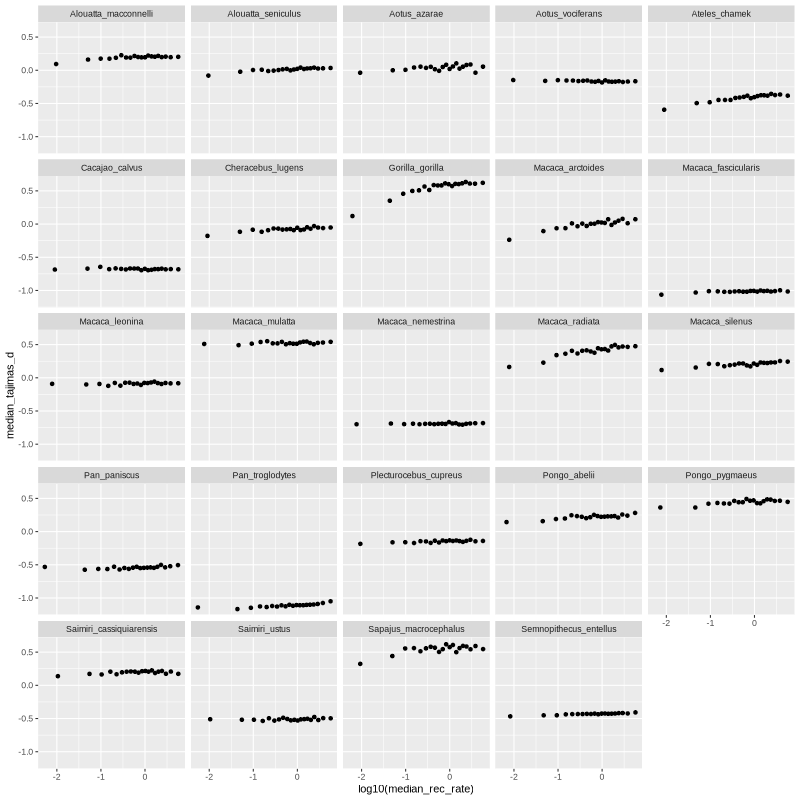

In [7]:
%%R -w 800 -h 800
df_summary %>%
    ggplot(aes(x = log10(median_rec_rate), y = median_tajimas_d)) +
    geom_point() +
    facet_wrap(~species) 

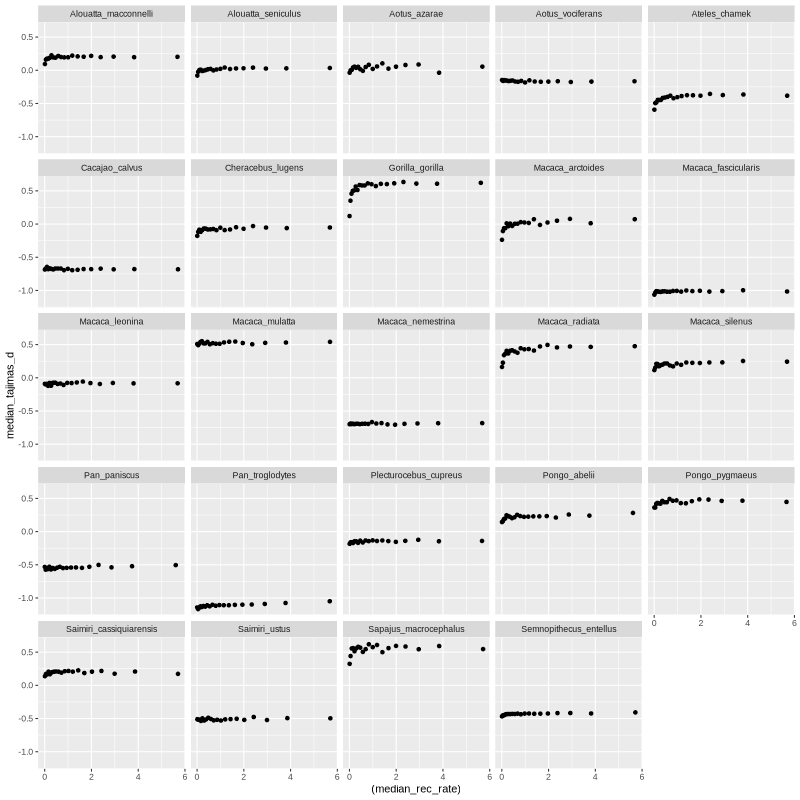

In [9]:
%%R -w 800 -h 800
df_summary %>%
    ggplot(aes(x = (median_rec_rate), y = median_tajimas_d)) +
    geom_point() +
    facet_wrap(~species) 

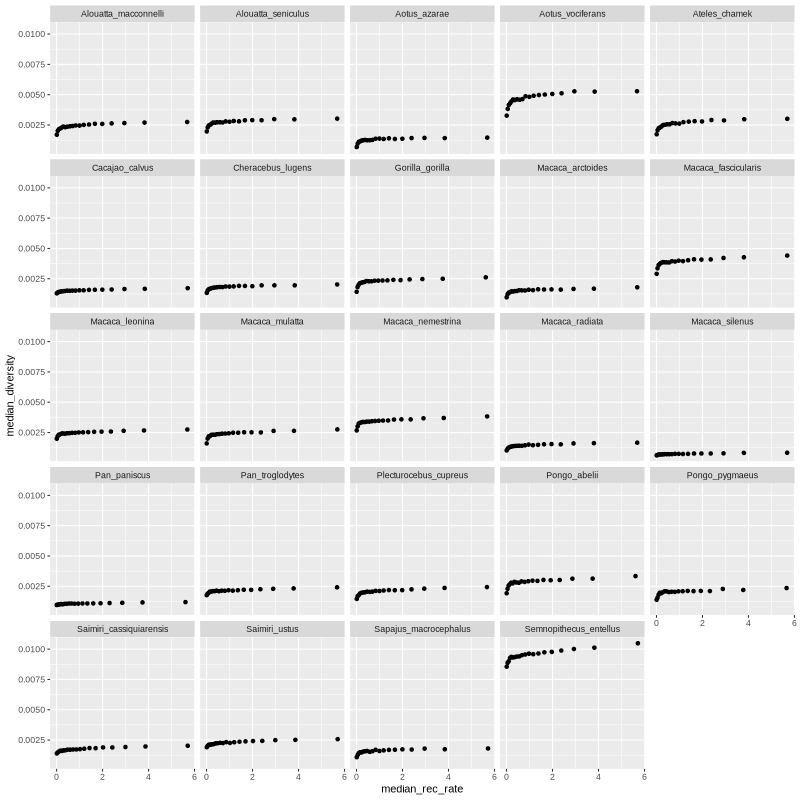

In [10]:
%%R -w 800 -h 800
df_summary %>%
    ggplot(aes(x = median_rec_rate, y = median_diversity)) +
    geom_point() +
    facet_wrap(~species) 

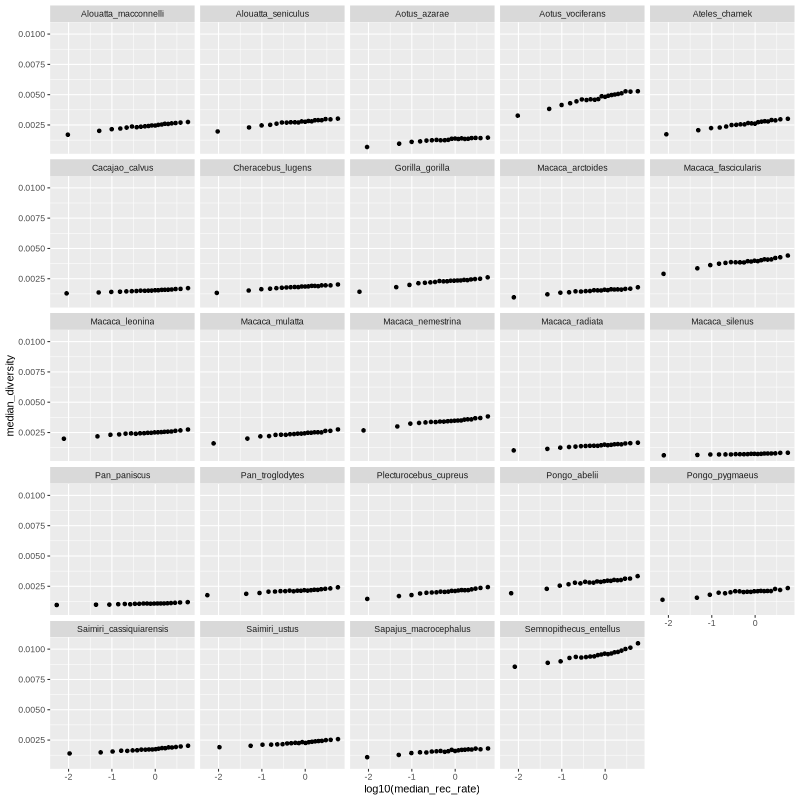

In [11]:
%%R -w 800 -h 800
df_summary %>%
    ggplot(aes(x = log10(median_rec_rate), y = median_diversity)) +
    geom_point() +
    facet_wrap(~species) 

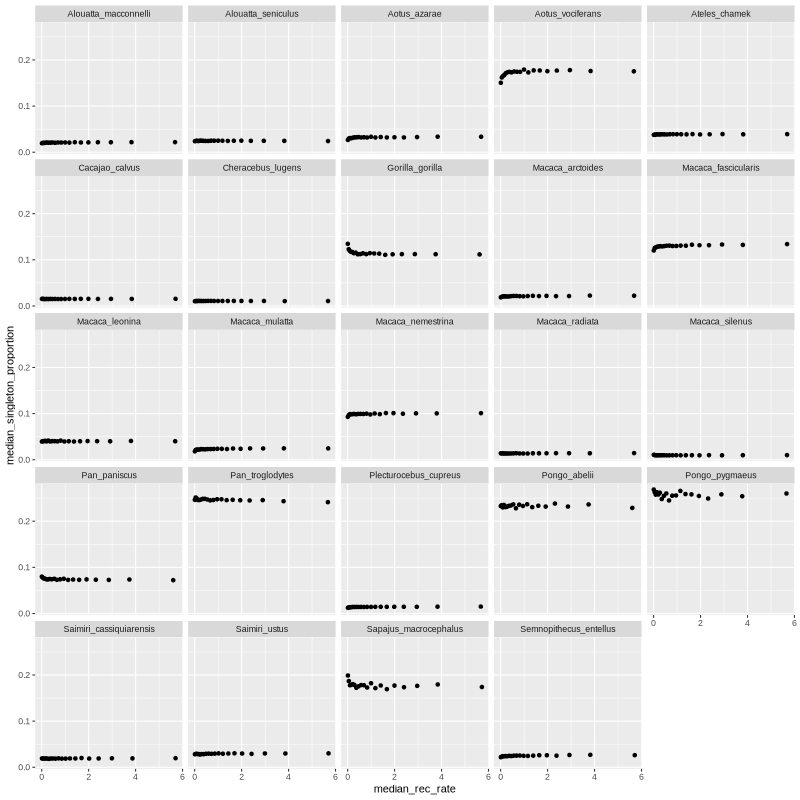

In [13]:
%%R -w 800 -h 800
df_summary %>%
    ggplot(aes(x = median_rec_rate, y = median_singleton_proportion)) +
    geom_point() +
    facet_wrap(~species) 

# Ne Modelling 

In [4]:
# Building the model
df = pd.read_csv('../data/Bergeron_et_al_2023_generationtimes_and_mutationrate.csv', sep=';',decimal=',')
df['m_generation']=df['Mutation rate per site per generation (m_generation)']
df['m_generation'] = pd.to_numeric(df['m_generation'])
df['Avg_age'] = pd.to_numeric(df['Avg_age'])
species_list=['Pan_troglodytes','Hylobates_lar','Homo_sapiens','Pithecia_pithecia','Mandrillus_leucophaeus','Saimiri_boliviensis_boliviensis']
primates = df[df['Species_name'].isin(species_list)]

In [7]:
basic_model = pm.Model()

with basic_model:
    alpha = pm.Normal('alpha',mu = 0, sigma = 0.1)
    beta = pm.Normal('beta',mu = 0, sigma = 0.1)
    sigma = pm.Exponential('sigma', lam=0.001)
    #expected outcome
    mu = alpha + beta * (primates['Avg_age'])
    # likelihood (sampling distribution) of observations 
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=primates['m_generation'])

In [8]:
log_scaled_g = pm.Model()

with log_scaled_g:
    alpha = pm.Normal('alpha',mu = 0, sigma = 0.1)
    beta = pm.Normal('beta',mu = 0, sigma = 0.1)
    sigma = pm.Exponential('sigma', lam=0.001)
    x = pm.MutableData("x", primates['Avg_age'])
    #expected outcome
    mu = alpha + beta * np.log10(x)
    # likelihood (sampling distribution) of observations 
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=primates['m_generation'])

/home/bjarkemp/miniforge3/envs/bircproject/lib/python3.12/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


In [9]:
halfnormal = pm.Model()

with halfnormal:
    alpha = pm.HalfNormal('alpha',sigma = 0.1)
    beta = pm.Normal('beta',mu = 0, sigma = 0.1)
    sigma = pm.Exponential('sigma', lam=0.001)
    x = pm.MutableData("x", primates['Avg_age'])
    #expected outcome
    mu = alpha + beta * np.log10(x)
    # likelihood (sampling distribution) of observations 
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=primates['m_generation'])

/home/bjarkemp/miniforge3/envs/bircproject/lib/python3.12/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


In [13]:
with basic_model:
    basic_model_trace = pm.sample(1000, tune=500, target_accept=0.99, return_inferencedata=True,
                            progressbar=True, cores=4, chains=4)

with log_scaled_g:
    log_scaled_g_trace = pm.sample(1000, tune=500, target_accept=0.99, return_inferencedata=True,
                            progressbar=True, cores=4, chains=4)

with halfnormal:
    halfnormal_trace = pm.sample(1000, tune=500, target_accept=0.99, return_inferencedata=True,
                            progressbar=True, cores=4, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 54 seconds.
There were 817 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 57 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 job

Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 100 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [35]:
# # Extract posterior samples for each model
# basic_posterior = basic_model_trace.posterior
# log_scaled_posterior = log_scaled_g_trace.posterior
# halfnormal_posterior = halfnormal_trace.posterior

# # Create dataframes for each model's parameters
# basic_params = pd.DataFrame({
#     'alpha': basic_posterior.alpha.values.flatten(),
#     'beta': basic_posterior.beta.values.flatten()
# })

# log_scaled_params = pd.DataFrame({
#     'alpha': log_scaled_posterior.alpha.values.flatten(),
#     'beta': log_scaled_posterior.beta.values.flatten()
# })

# halfnormal_params = pd.DataFrame({
#     'alpha': halfnormal_posterior.alpha.values.flatten(),
#     'beta': halfnormal_posterior.beta.values.flatten()
# })

# # Save to CSV files
# basic_params.to_csv('../results/Ne_modelling/basic_model_parameters.csv', index=False)
# log_scaled_params.to_csv('../results/Ne_modelling/log_scaled_parameters.csv', index=False)
# halfnormal_params.to_csv('../results/Ne_modelling/halfnormal_parameters.csv', index=False)

In [14]:
with halfnormal:
    pm.compute_log_likelihood(halfnormal_trace)
with basic_model:
    pm.compute_log_likelihood(basic_model_trace)
with log_scaled_g:
    pm.compute_log_likelihood(log_scaled_g_trace)

df_comp_loo = az.compare({"basic_model": basic_model_trace, "log_scaled_g": log_scaled_g_trace, 'halfnormal':halfnormal_trace})
# df_comp_loo.to_csv('../results/Ne_modelling/comparison.csv')

Output()

Output()

Output()

In [36]:
# Predicting Ne 
generation_times = pd.read_csv('../data/Kuderna_et_al_2023.csv', usecols=['SPECIES_BINOMIAL', 'GENERATION_LENGTH'])
highest_pi = pd.read_csv('../results/stats/diversity_in_highest_recombination_bin.csv')
parameters_mu_model = pd.read_csv('../results/Ne_modelling/halfnormal_parameters.csv', sep = ',')
# Merge with highest_pi and rename column to match
generation_times = generation_times.merge(
    highest_pi,
    left_on='SPECIES_BINOMIAL',
    right_on='species',
    how='inner'
).drop('SPECIES_BINOMIAL', axis=1)

In [43]:
# Create function to predict mutation rate using the model parameters
def predict_mutation_rate(generation_time, alpha, beta):
    return alpha + beta * np.log10(generation_time)

# Initialize storage for results
results = []

# For each species
for _, row in generation_times.iterrows():
    species = row['species']
    gen_time = row['GENERATION_LENGTH']
    
    # Generate predictions using all posterior samples
    predictions = predict_mutation_rate(
        gen_time,
        parameters_mu_model['alpha'].values,
        parameters_mu_model['beta'].values
    )
    
    # Calculate median and HDI
    median_rate = np.median(predictions)
    hdi = az.hdi(predictions, hdi_prob=0.95)
    
    results.append({
        'species': species,
        'generation_time': gen_time,
        'median_predicted_rate': median_rate,
        'hdi_lower': hdi[0],
        'hdi_upper': hdi[1]
    })

# Convert to dataframe
results_df = pd.DataFrame(results)

In [48]:
# Calculate Ne using the relationship Ne = pi/(4*mu)
results_df['Ne_median'] = results_df.merge(
    generation_times[['species', 'median_diversity']], 
    on='species'
)['median_diversity'] / (4 * results_df['median_predicted_rate'])

# Calculate Ne lower bound (using upper mutation rate bound)
results_df['Ne_lower'] = results_df.merge(
    generation_times[['species', 'median_diversity']], 
    on='species'
)['median_diversity'] / (4 * results_df['hdi_upper'])

# Calculate Ne upper bound (using lower mutation rate bound)
results_df['Ne_upper'] = results_df.merge(
    generation_times[['species', 'median_diversity']], 
    on='species'
)['median_diversity'] / (4 * results_df['hdi_lower'])

In [53]:
results_df = results_df.merge(
    generation_times[['species', 'median_diversity']], 
    on='species',
    how='left')
results_df

,species,generation_time,median_predicted_rate,hdi_lower,hdi_upper,Ne_median,Ne_lower,Ne_upper,median_diversity
0,Allenopithecus_nigroviridis,10.0,8.377808e-09,7.317695e-09,9.548462e-09,53365.192548,46822.551358,61096.196593,0.001788
1,Allochrocebus_lhoesti,10.0,8.377808e-09,7.317695e-09,9.548462e-09,92754.971205,81383.092529,106192.364069,0.003108
2,Allochrocebus_preussi,10.0,8.377808e-09,7.317695e-09,9.548462e-09,105337.817164,92423.265402,120598.084235,0.003530
3,Allochrocebus_solatus,10.0,8.377808e-09,7.317695e-09,9.548462e-09,124435.891665,109179.891424,142462.892708,0.004170
4,Alouatta_belzebul,12.0,8.871836e-09,7.754292e-09,9.971834e-09,62275.725130,55406.054463,71250.858989,0.002210
...,...,...,...,...,...,...,...,...,...
176,Trachypithecus_laotum,11.0,8.635916e-09,7.537494e-09,9.742647e-09,35028.130199,31049.057749,40132.700340,0.001210
177,Trachypithecus_leucocephalus,12.0,8.871836e-09,7.754292e-09,9.971834e-09,10989.833846,9777.539023,12573.680998,0.000390
178,Trachypithecus_melamera,12.0,8.871836e-09,7.754292e-09,9.971834e-09,37196.360711,33093.209001,42557.074147,0.001320
179,Varecia_rubra,8.0,7.769189e-09,6.667105e-09,9.038913e-09,50520.072865,43423.362126,58871.131044,0.001570


In [54]:
# Display species with highest Ne
print("Top 5 species by effective population size:")
print(results_df.nlargest(5, 'Ne_median')[['species', 'Ne_median']])

print("\nBottom 5 species by effective population size:")
print(results_df.nsmallest(5, 'Ne_median')[['species', 'Ne_median']])

Top 5 species by effective population size:
                    species      Ne_median
57     Chiropotes_albinasus  359929.786424
168  Semnopithecus_entellus  312837.542359
40     Cercopithecus_cephus  282172.305064
39   Cercopithecus_ascanius  228945.478780
43      Cercopithecus_lowei  225458.341179

Bottom 5 species by effective population size:
                          species     Ne_median
10              Alouatta_palliata   5106.373640
121                     Mico_spnv   7527.151326
156           Rhinopithecus_bieti   7979.742367
177  Trachypithecus_leucocephalus  10989.833846
157       Rhinopithecus_roxellana  12107.195315


In [55]:
# Display species with highest Ne
print("Top 5 species by effective population size:")
print(results_df.nlargest(5, 'median_diversity')[['species', 'median_diversity']])

print("\nBottom 5 species by effective population size:")
print(results_df.nsmallest(5, 'median_diversity')[['species', 'median_diversity']])

Top 5 species by effective population size:
                    species  median_diversity
57     Chiropotes_albinasus          0.012062
168  Semnopithecus_entellus          0.010484
40     Cercopithecus_cephus          0.008769
39   Cercopithecus_ascanius          0.008125
43      Cercopithecus_lowei          0.007300

Bottom 5 species by effective population size:
                          species  median_diversity
10              Alouatta_palliata          0.000170
121                     Mico_spnv          0.000210
156           Rhinopithecus_bieti          0.000290
96         Leontopithecus_rosalia          0.000387
177  Trachypithecus_leucocephalus          0.000390


In [59]:
# selected_columns = ['species', 'median_predicted_rate', 'Ne_median', 'Ne_upper', 'Ne_lower']
# results_df[selected_columns].to_csv('../results/Ne_modelling/predicted_Ne.csv', index=False)

In [60]:
## Merge Ne to the actual data
# total = pd.read_csv('../results/stats/all_species.combined.stats.filtered.csv', sep = ',')
# ne_df = pd.read_csv('../results/Ne_modelling/predicted_Ne.csv')
# merged_df = total.merge(ne_df, on='species', how='left')
# merged_df.to_csv('../results/stats/all_species_ne.combined.stats.filtered.csv')

# Relative Reduction Model

In [ ]:
%%R
#prepare data
